In [1]:
# On Google colab, we must ensure scipy is up to date
#!pip install -U scipy==1.5.3
#!pip install scikit-learn==0.23.2
#!pip install pandas==1.1.4
#!pip install matplotlib==3.3.3

In [2]:
import os
import urllib.request
import zipfile
from functools import lru_cache

import pandas as pd
import numpy as np
import scipy
import scipy.sparse

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import FeatureHasher
import joblib

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

plt.style.use('ggplot')

## Download Data

In [3]:
def download_dataset():
  urllib.request.urlretrieve(
    "https://go.criteois.com/criteo-research-attribution-dataset.zip", 
    "criteo_attribution_dataset.zip"
  )
  
  with zipfile.ZipFile("criteo_attribution_dataset.zip", "r") as zip_ref:
    zip_ref.extractall("criteo_attribution_dataset")

In [4]:
dataset_path = 'criteo_attribution_dataset/criteo_attribution_dataset.tsv.gz'

if not os.path.exists(dataset_path):
  download_dataset()

## Preprocessing

### Take a data sample
In order to run the code on Google colab or a personal computer, we might want to sub-sample a part of the user timelines.

In [5]:
DEBUG_SAMPLE = 1.0

In [6]:
def get_sampled_dataset(debug_sample=1.0):
  df = pd.read_csv(dataset_path, sep='\t', compression="gzip")
  uid_and_salt = df['uid'].astype(str) + 'hash_salt_for_sampling'
  hashed_uid_and_salt = pd.util.hash_pandas_object(uid_and_salt, index=False)
  random_column_based_on_uid = hashed_uid_and_salt / np.iinfo(np.uint64).max
  return df[random_column_based_on_uid < debug_sample]

sampled_dataset = get_sampled_dataset(DEBUG_SAMPLE)
sampled_dataset

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16468022,2671199,5767906,4869923,0,-1,-1,0,1,-1,-1,...,482560,30763035,26597095,13113052,29196072,5824236,30763035,18391143,29196072,8661623
16468023,2671199,6852682,10002432,0,-1,-1,0,0,-1,-1,...,971748,25259032,9312274,10979162,29196072,32440044,29196072,27259439,29196072,8661620
16468024,2671199,16638720,7061828,0,-1,-1,0,0,-1,-1,...,268431,30763035,5824235,29542751,29196072,5824237,29196072,3696777,29196072,21091111
16468025,2671199,3032300,5061834,0,-1,-1,0,1,-1,-1,...,-1,1973606,26597096,28944164,29196072,26611392,1973606,5642940,14911188,29196072


### Clean timelines
Split timelines having multiple conversions and remove timelines that have missing clicks

In [7]:
def split_timelines(df):
  """Some timelines have several conversions and conversion times.
  For the sake of simplicity, we split the timelines as soon as a conversion occurs.
  """
  conversion_timestamps = df.groupby('timeline_id').agg({'conversion_timestamp': lambda x: sorted(list(set(x)))})
  conversion_timestamps.rename(columns={'conversion_timestamp': 'conversion_timestamps'}, inplace=True)

  def get_next_conversion_timestamp(data):
    next_conversion_index = np.searchsorted(data['conversion_timestamps'], data['timestamp'])
    if next_conversion_index == len(data['conversion_timestamps']):
      return 'nnc' # no next conversion
    else:
      return str(data['conversion_timestamps'][next_conversion_index])

  df_with_ct = df.merge(conversion_timestamps, on='timeline_id', how='outer', validate="many_to_one")

  matched_displays_mask = df_with_ct['conversion_timestamp'] > 0
  df_with_ct['next_conversion_timestamp'] = np.where(
      matched_displays_mask,
      df_with_ct['conversion_timestamp'].astype(str),
      df_with_ct.apply(get_next_conversion_timestamp, axis=1)
  )
  
  df_with_ct.rename(columns={'timeline_id': 'timeline_id_no_split'}, inplace=True)
  df_with_ct['timeline_id'] = df_with_ct['timeline_id_no_split'].astype(str) + '_' + df_with_ct['next_conversion_timestamp']
  
  original_column_order = list(df.columns)
  return df_with_ct[original_column_order]

In [8]:
debug = True
if debug:
  test_df = pd.DataFrame([
    {'timeline_id': 1, 'timestamp': 1, 'conversion_timestamp': -1},
    {'timeline_id': 1, 'timestamp': 2, 'conversion_timestamp': -1},
    {'timeline_id': 1, 'timestamp': 3, 'conversion_timestamp': 6},
    {'timeline_id': 1, 'timestamp': 4, 'conversion_timestamp': 6},
    {'timeline_id': 1, 'timestamp': 7, 'conversion_timestamp': -1},
    {'timeline_id': 1, 'timestamp': 8, 'conversion_timestamp': 10},
    {'timeline_id': 1, 'timestamp': 9, 'conversion_timestamp': 10},
    {'timeline_id': 1, 'timestamp': 11, 'conversion_timestamp': -1},
    {'timeline_id': 1, 'timestamp': 12, 'conversion_timestamp': -1},
    {'timeline_id': 2, 'timestamp': 1, 'conversion_timestamp': -1},
    {'timeline_id': 2, 'timestamp': 2, 'conversion_timestamp': -1},
    # Edge case : sometimes (rarely, the conversion is not mapped to the next one)
    {'timeline_id': 3, 'timestamp': 1, 'conversion_timestamp': -1},
    {'timeline_id': 3, 'timestamp': 2, 'conversion_timestamp': 7},
    {'timeline_id': 3, 'timestamp': 3, 'conversion_timestamp': 4},
    {'timeline_id': 3, 'timestamp': 5, 'conversion_timestamp': 7},
    {'timeline_id': 3, 'timestamp': 6, 'conversion_timestamp': 7},
  ])
  split_test_df = pd.DataFrame([
    {'timeline_id': '1_6', 'timestamp': 1, 'conversion_timestamp': -1},
    {'timeline_id': '1_6', 'timestamp': 2, 'conversion_timestamp': -1},
    {'timeline_id': '1_6', 'timestamp': 3, 'conversion_timestamp': 6},
    {'timeline_id': '1_6', 'timestamp': 4, 'conversion_timestamp': 6},
    {'timeline_id': '1_10', 'timestamp': 7, 'conversion_timestamp': -1},
    {'timeline_id': '1_10', 'timestamp': 8, 'conversion_timestamp': 10},
    {'timeline_id': '1_10', 'timestamp': 9, 'conversion_timestamp': 10},
    {'timeline_id': '1_nnc', 'timestamp': 11, 'conversion_timestamp': -1},
    {'timeline_id': '1_nnc', 'timestamp': 12, 'conversion_timestamp': -1},
    {'timeline_id': '2_nnc', 'timestamp': 1, 'conversion_timestamp': -1},
    {'timeline_id': '2_nnc', 'timestamp': 2, 'conversion_timestamp': -1},
    # Edge case
    {'timeline_id': '3_4', 'timestamp': 1, 'conversion_timestamp': -1},
    {'timeline_id': '3_7', 'timestamp': 2, 'conversion_timestamp': 7},
    {'timeline_id': '3_4', 'timestamp': 3, 'conversion_timestamp': 4},
    {'timeline_id': '3_7', 'timestamp': 5, 'conversion_timestamp': 7},
    {'timeline_id': '3_7', 'timestamp': 6, 'conversion_timestamp': 7},
  ])
  assert split_test_df.equals(split_timelines(test_df))

In [9]:
def remove_uncomplete_timelines(df):
  """Since the data set consists of 30 consecutive days, it contains some timelines that
  had started before and hence are uncomplete in our training example.
  For the sake of simplicity, we remove them.
  """
  # First assert that for all timelines, if a display is associated to a conversion (click_nb > 0)
  # then, all click displays share the same click number
  click_nb_check_df = df[df['click_nb'] > 0].groupby('timeline_id').agg({'click_nb': lambda x: len(set(x))})
  assert np.all(click_nb_check_df['click_nb'] == 1)

  click_nb_in_timelines = df.groupby('timeline_id').agg({'click': 'sum'})
  click_nb_in_timelines.rename(columns={'click': 'click_nb_in_timeline'}, inplace=True)

  df_with_click_nb = df.merge(click_nb_in_timelines, on='timeline_id', how='outer', validate="many_to_one")

  # We keep if there is either no click or if all clicks are available
  keep_display = (df_with_click_nb['click_nb'] == -1) | (df_with_click_nb['click_nb_in_timeline'] == df_with_click_nb['click_nb'])
  filtered_df = df_with_click_nb[keep_display].reset_index()

  original_column_order = df.columns
  return filtered_df[original_column_order]

In [10]:
debug = True
if debug:
  test_df = pd.DataFrame([
    {'timeline_id': 1, 'click': 0, 'click_nb': -1},
    {'timeline_id': 1, 'click': 0, 'click_nb': -1},
    {'timeline_id': 1, 'click': 0, 'click_nb': -1},
    {'timeline_id': 2, 'click': 0, 'click_nb': -1},
    {'timeline_id': 2, 'click': 1, 'click_nb': 2},
    {'timeline_id': 2, 'click': 1, 'click_nb': 2},
    {'timeline_id': 3, 'click': 1, 'click_nb': 3},
    {'timeline_id': 3, 'click': 1, 'click_nb': 3},
    {'timeline_id': 3, 'click': 0, 'click_nb': -1},
  ])
  removed_uncomplete_test_df = pd.DataFrame([
    {'timeline_id': 1, 'click': 0, 'click_nb': -1},
    {'timeline_id': 1, 'click': 0, 'click_nb': -1},
    {'timeline_id': 1, 'click': 0, 'click_nb': -1},
    {'timeline_id': 2, 'click': 0, 'click_nb': -1},
    {'timeline_id': 2, 'click': 1, 'click_nb': 2},
    {'timeline_id': 2, 'click': 1, 'click_nb': 2},
    {'timeline_id': 3, 'click': 0, 'click_nb': -1},
  ])
  assert removed_uncomplete_test_df.equals(remove_uncomplete_timelines(test_df))

In [11]:
def get_nb_clicks(df):
  """Get the total number of clicks made by this timeline_id so far
  """
  click_timestamps = df[df['click'] == 1].groupby('timeline_id').agg({'timestamp': lambda x: sorted(list(set(x)))})
  click_timestamps.rename(columns={'timestamp': 'click_timestamps'}, inplace=True)

  def get_nb_clicks_for_timeline_id(row):
    if isinstance(row['click_timestamps'], list) and len(row['click_timestamps']) > 0:
      return np.searchsorted(row['click_timestamps'], row['timestamp'])
    else:
      return 0

  df_with_ct = df.merge(click_timestamps, on='timeline_id', how='outer', validate="many_to_one")
  df_with_ct['nb_clicks'] = df_with_ct.apply(get_nb_clicks_for_timeline_id, axis=1)
  
  original_column_order = list(df.columns) + ['nb_clicks']
  return df_with_ct[original_column_order]

In [12]:
debug = True
if debug:
  test_df = pd.DataFrame([
    {'timeline_id': 1, 'timestamp': 1, 'click': 0},
    {'timeline_id': 1, 'timestamp': 2, 'click': 0},
    {'timeline_id': 1, 'timestamp': 3, 'click': 1},
    {'timeline_id': 1, 'timestamp': 4, 'click': 1},
    {'timeline_id': 1, 'timestamp': 7, 'click': 0},
    {'timeline_id': 1, 'timestamp': 8, 'click': 1},
    {'timeline_id': 1, 'timestamp': 9, 'click': 1},
    {'timeline_id': 1, 'timestamp': 11, 'click': 0},
    {'timeline_id': 1, 'timestamp': 12, 'click': 0},
    {'timeline_id': 2, 'timestamp': 1, 'click': 0},
    {'timeline_id': 2, 'timestamp': 2, 'click': 0},
  ])
  nb_clicks_test_df = pd.DataFrame([
    {'timeline_id': 1, 'timestamp': 1, 'click': 0, "nb_clicks": 0},
    {'timeline_id': 1, 'timestamp': 2, 'click': 0, "nb_clicks": 0},
    {'timeline_id': 1, 'timestamp': 3, 'click': 1, "nb_clicks": 0},
    {'timeline_id': 1, 'timestamp': 4, 'click': 1, "nb_clicks": 1},
    {'timeline_id': 1, 'timestamp': 7, 'click': 0, "nb_clicks": 2},
    {'timeline_id': 1, 'timestamp': 8, 'click': 1, "nb_clicks": 2},
    {'timeline_id': 1, 'timestamp': 9, 'click': 1, "nb_clicks": 3},
    {'timeline_id': 1, 'timestamp': 11, 'click': 0, "nb_clicks": 4},
    {'timeline_id': 1, 'timestamp': 12, 'click': 0, "nb_clicks": 4},
    {'timeline_id': 2, 'timestamp': 1, 'click': 0, "nb_clicks": 0},
    {'timeline_id': 2, 'timestamp': 2, 'click': 0, "nb_clicks": 0},
  ])
  assert nb_clicks_test_df.equals(get_nb_clicks(test_df))

### Enrich dataset

In [13]:
CACHE_DIRECTORY = 'cache'


def get_preprocessed_dataset(original_df, use_cache=True):
  """Apply all preprocessing on the original data set
  """
  # For an easier experimentation, we cache the preprocessed data
  df_identifier = '_'.join(map(str, original_df.shape))
  cache_path = os.path.join(CACHE_DIRECTORY, df_identifier, 'preprocess.pkl')
  if os.path.exists(cache_path) and use_cache:
    df = pd.read_pickle(cache_path)

  else:
    df = original_df.copy()

    # Consider each campaign independently
    df['timeline_id'] = df['uid'].astype(str) + '_' + df['campaign'].astype(str)

    # Apply previously introduced preprocessings
    df = split_timelines(df)
    df = remove_uncomplete_timelines(df)
    df = get_nb_clicks(df)

    # Add extra row variables
    df['day'] = np.floor(df['timestamp'] / 86400.).astype(int)

    # We bucketize time since last click such that all buckets have a sufficient amount of displays
    df['time_since_last_click_bucketized'] = np.where(
      df['time_since_last_click'] == -1, -1,
      np.where(
        df['time_since_last_click'] < 20 * 3600,
        np.log(1 + df['time_since_last_click'] / 60).astype(int),
        7 + (df['time_since_last_click'] / (2 * 24 * 3600)).astype(int)
      )
    )

    # Add last click attribution
    df['last_click'] = df['attribution'] * (df['click_pos'] == df['click_nb'] - 1).astype(int)

    # Precompute the total reward per timeline_id (called V in the paper)
    total_timeline_id_reward = df.groupby('timeline_id').agg({'last_click': 'sum'})
    total_timeline_id_reward.columns = ['total_timeline_id_rewards']
    df = df.merge(total_timeline_id_reward, on='timeline_id', how='outer', validate="many_to_one")

    # Save preprocessed data to cache folder
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    df.to_pickle(cache_path)
  
  # assert there is at most one conversion per timeline
  assert set(df['total_timeline_id_rewards'].unique()) == {0, 1}

  return df

In [14]:
preprocessed_dataset = get_preprocessed_dataset(sampled_dataset, use_cache=True)

### Dataset statistics

In [15]:
def print_stats(df, timeline_id):
  df = df.copy()
  n_displays = len(df)
  n_users = len(df[timeline_id].unique())
  n_conversions = sum(df.groupby(timeline_id).agg({'attribution': 'sum'}).values.ravel() > 0)
  print(f'The dataset consists in {n_displays} displays from {n_users} timelines among which {n_conversions} converted')

print_stats(sampled_dataset, 'uid')
print_stats(preprocessed_dataset, 'timeline_id')

The dataset consists in 16468027 displays from 6142256 timelines among which 179803 converted
The dataset consists in 16256483 displays from 8015218 timelines among which 195800 converted


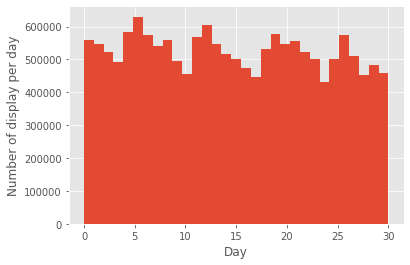

In [16]:
def plot_n_displays_per_day(df):
  df.day.hist(bins=len(df.day.unique()))
  plt.ylabel('Number of display per day')
  plt.xlabel('Day')

plot_n_displays_per_day(preprocessed_dataset)

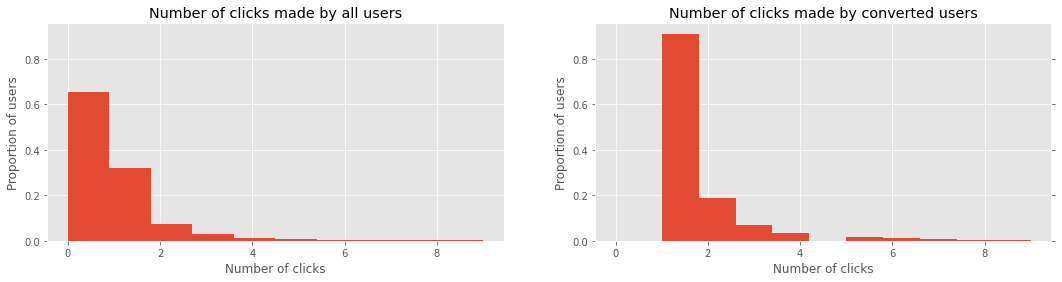

In [17]:
def plot_n_clicks_per_user(df):
  groupped_by_user = df.groupby('timeline_id').agg({'click': ['count', 'sum'], 'attribution': ['sum']})
  converted_users = groupped_by_user[groupped_by_user['attribution']['sum'] > 0]

  fig, axes = plt.subplots(1, 2, figsize=(18, 4), sharex=True, sharey=True)
  max_clicks = 10
  groupped_by_user['click']['sum'][groupped_by_user['click']['sum'] < max_clicks].hist(density=True, bins=max_clicks, ax=axes[0])
  axes[0].set_title('Number of clicks made by all users')
  axes[0].set_xlabel('Number of clicks')
  axes[0].set_ylabel('Proportion of users')

  converted_users['click']['sum'][converted_users['click']['sum'] < max_clicks].hist(density=True, bins=max_clicks, ax=axes[1])
  axes[1].set_title('Number of clicks made by converted users')
  axes[1].set_xlabel('Number of clicks')
  axes[1].yaxis.set_tick_params(reset=True)
  axes[1].set_ylabel('Proportion of users')

plot_n_clicks_per_user(preprocessed_dataset)

### Featuring

In [18]:
FEATURES = ['campaign', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'time_since_last_click_bucketized', 'nb_clicks']

def features_to_list_of_strings(row):
  return [f'{feature}_{row[feature]}' for feature in row.index]


def get_labels_and_features(preprocessed_dataset, hash_space=2**13, use_cache=True):
  """Get labels and features to run machine learning algorithms.
  """
  LABELS_FILE = 'labels.npy'
  FEATURES_FILE = 'features.npz'

  dataset_identifier = '_'.join(map(str, preprocessed_dataset.shape))
  label_features_identifier = f'{"_".join(FEATURES)}'
  cache_path = os.path.join(CACHE_DIRECTORY, dataset_identifier, label_features_identifier, str(hash_space))
  label_cache_path = os.path.join(cache_path, LABELS_FILE)
  features_cache_path = os.path.join(cache_path, FEATURES_FILE)
  
  if use_cache and os.path.exists(label_cache_path) and os.path.exists(features_cache_path):
    labels = np.load(label_cache_path)
    features = scipy.sparse.load_npz(features_cache_path)

  else:
    labels = preprocessed_dataset['last_click'].astype(float).values
    raw_features = preprocessed_dataset[FEATURES]

    # The categorical features are hashed using the hashing trick
    features_as_list_of_strings = raw_features.apply(features_to_list_of_strings, axis=1)
    hasher = FeatureHasher(n_features=hash_space, input_type='string', alternate_sign=False)
    features = hasher.fit_transform(features_as_list_of_strings)
    os.makedirs(cache_path, exist_ok=True)
    np.save(label_cache_path, labels)
    scipy.sparse.save_npz(features_cache_path, features)

  return labels, features

In [19]:
def split_train_test_mask(preprocessed_dataset, ratio=0.8):
  """We split the dataset into train and test parts by timeline_id
  (learn on a part of the population and test on the other part)
  """
  timeline_id_and_salt = preprocessed_dataset['timeline_id'].astype(str) + 'hash_salt_for_train_test_split'
  hashed_timeline_id_and_salt = pd.util.hash_pandas_object(timeline_id_and_salt, index=False)
  random_column_based_on_timeline_id = hashed_timeline_id_and_salt / np.iinfo(np.uint64).max
  return random_column_based_on_timeline_id < ratio


def get_train_test_labels_and_features(preprocessed_dataset, is_training_mask, hash_space=2**13, use_cache=True):
  labels, features = get_labels_and_features(preprocessed_dataset, hash_space=hash_space, use_cache=use_cache)

  return (
    labels[is_training_mask], features[is_training_mask],
    labels[~is_training_mask], features[~is_training_mask],
  )

## Learning

In [20]:
# General config for the machine learning models
C_REGULARIZATION = 1
HASH_SPACE = int(2**13)
MAX_ITER = 1000

### Last touch attribution

In [21]:
def train_last_touch_model(labels, features, c_regularization):
  last_touch_model = LogisticRegression(max_iter=MAX_ITER, C=c_regularization)
  last_touch_model.fit(features, labels)
  return last_touch_model

### Core Attribution

#### Logistic regression with continuous labels

We choose Logistic regression from scikit-learn as our ML algorithm. The logistic regression loss that we minimize is

$$
l(y, p) = \mathbb{1}_{y = 1} \log(p) + \mathbb{1}_{y = 0} \log(1 - p)
$$

However, our fixed-point algorithm will make appear continuous labels ($y$ is the result of the internal attribution $\mu$) that cannot be fit with scikit-learn's logistic regression. Indeed, this logisitic regression can only take 0-1 labels as input.

A basic extension of logistic regression to learn with a continuous label $y \in [0, 1]$, consisits in minimizing the binomial loss that writes:

$$
l(y, p) = y \log(p) + (1 - y) \log(1 - p)
$$

In order to minimize this loss with a logistic regression optimizer, we generate a new dataset in which we duplicate the rows and assign them a weight : a "positive" row a label 1 and a weight $y$ and a "negative" row with a label 0 and a weight $1 - y$.

In [22]:
class CountinuousLogisticRegression(LogisticRegression):
  
  @staticmethod
  def from_countinuous_to_weighted_binary_labels(labels, features):
    """Transforms a dataset with continuous labels into a bigger dataset with weighted 
    binary labels. See explanation above.
    """
    weigths_positive = labels
    weigths_negative = 1 - labels
    label_positive = np.ones_like(labels)
    label_negative = np.zeros_like(labels)

    weights = np.hstack((weigths_positive, weigths_negative))
    weighted_labels = np.hstack((label_positive, label_negative))
    weighted_features = scipy.sparse.vstack((features, features))

    mask = (weights > 0)
    return weighted_labels[mask], weighted_features[mask], weights[mask]
  
  def fit(self, X, y):
    # 1. Generate dataset, use continuous labels to weighted dataset trick
    weighted_labels, weighted_features, weights = self.from_countinuous_to_weighted_binary_labels(y, X)

    # 2. Train model
    return LogisticRegression.fit(self, weighted_features, weighted_labels, sample_weight=weights)

#### Fixed point iterations

We are implementing the following fixed-point algorithm

1. Generate dataset
   $$ \mathcal{D}^{(k + 1)} \;\; = \;\; \big\{
   (x, y) = \big((s_n)^j, \mu^{(k)}(j, s_n) \big) \text{ for } n \in [N] \text{ and } j \in [\ell(s_n)] 
   \big\}$$
  
2. With a ML algorithm, train $\nu^{(k + 1)}$ on $\mathcal{D}^{(k + 1)}$ \\
   $$ \nu^{(k + 1)} \;\; = \;\; (s) \mapsto \mathbb{E}_{(x, y) \in \mathcal{D}^{(k + 1)}} \big[ y\; | \; x=s \big] $$

3. Set $\mu$ with fixed-point characterization 
   $$\mu^{(k + 1)} \;\; = \;\; (i, s) \mapsto \frac{\nu^{(k + 1)}(s^i)}{\sum_{j = 1}^{\ell(s)} \nu^{(k + 1)}(s^j)} V(s)$$

In [23]:
def run_one_iteration(labels, features, is_eligible, timeline_ids, total_timeline_id_reward, c_regularization):
  """Return the new labels obtained after one iteration of the core attribution
  fixed point algorithm
  """
  # In our dataset, we know in advance that many displays will not get any
  # credit from the internal attribution. Either:
  #   1. because they have not been clicked
  #   2. because no attributed sales were corresponding to this timeline_id.
  # These displays remain attached with a zero label while the remaining ones
  # will have a variable label computed with the fixed point iterations.
  to_update_mask = (total_timeline_id_reward > 0) & is_eligible

  labels_to_update, features_to_update = labels[to_update_mask], features[to_update_mask]
  
  # Step 2, compute valuations
  model = CountinuousLogisticRegression(max_iter=MAX_ITER, C=c_regularization)
  model.fit(features, labels)
  
  model_predictions = model.predict_proba(features_to_update)[:, 1]
  scenario_valuation = model_predictions

  predictions_per_display_to_update = pd.DataFrame({
    'feature_index': np.arange(scenario_valuation.shape[0]), 
    'timeline_id': timeline_ids[to_update_mask],
    'scenario_valuation': scenario_valuation,
    'total_timeline_id_rewards': total_timeline_id_reward[to_update_mask],
  })
  
  # Step 3, compute new labels proportionally to the display valuations
  total_timeline_id_valuation = (
    predictions_per_display_to_update
    .groupby('timeline_id')
    .agg(total_timeline_id_valuation=('scenario_valuation', 'sum'))
    .reset_index()
  )
  
  predictions_per_display_to_update = predictions_per_display_to_update.merge(
    total_timeline_id_valuation, on='timeline_id', how='left')
  
  # merge shuffles the lines, we must reorder them by feature index
  predictions_per_display_to_update.sort_values('feature_index', inplace=True)

  # Use fixed point characterization to update the labels
  updated_labels = (
    predictions_per_display_to_update['scenario_valuation'] 
    / predictions_per_display_to_update['total_timeline_id_valuation'] 
    * predictions_per_display_to_update['total_timeline_id_rewards']
  ).values

  next_labels = labels
  next_labels[to_update_mask] = updated_labels

  # Ensure we have just spread the labels
  np.testing.assert_almost_equal(sum(updated_labels), sum(labels))
  np.testing.assert_almost_equal(sum(next_labels), sum(labels))

  return model, next_labels

In [24]:
def get_train_test_extra_core_attribution_attributes(preprocessed_dataset, is_training_mask):
  """Beyond labels and features, we need timelines identifiers to run core attribution
  """
  is_clicked, timeline_ids, total_timeline_id_rewards = preprocessed_dataset['click'] > 0, preprocessed_dataset['timeline_id'], preprocessed_dataset['total_timeline_id_rewards']
  return (
    is_clicked[is_training_mask], timeline_ids[is_training_mask], total_timeline_id_rewards[is_training_mask],
    is_clicked[~is_training_mask], timeline_ids[~is_training_mask], total_timeline_id_rewards[~is_training_mask],
  )


def train_core_attribution_model(
  n_iterations, labels, features, timeline_ids, timeline_rewards, is_eligible, c_regularization, callback=None
):
  # Initialize the labels with the labels from the training set (set with last touch attribution)
  current_labels = labels.astype(float).copy()

  for _ in range(n_iterations):
    model, current_labels = run_one_iteration(
      current_labels, features, is_eligible, timeline_ids, timeline_rewards, c_regularization)

    if callback is not None:
      callback(model)

  return model

## Metrics

### Additivity likelihood

We call additivity likelihood

$$
\mathcal{L}^{\sf A}(\nu) = \dfrac{1}{T} \sum \limits_{t} \left[ y_t \cdot \ln \left(\sum_{q =1}^{\ell(s_t)}\nu(s_t^q) \right)  - \sum_{q =1}^{\ell(s_t)}\nu (s_t^q)\right]
$$

We can use it to check whether the algorithm convergesand to evaluate the quality the output, see Section 5.1.

In [25]:
def additivity_likelihood(model_or_predictions, features, timeline_ids, timeline_id_rewards):
  # Get model predictions for all displays
  if hasattr(model_or_predictions, 'predict_proba'):
    model_predictions = model_or_predictions.predict_proba(features)[:, 1]
  else:
    model_predictions = model_or_predictions

  # Gather the attributions per timeline and obtain the sum of the predictions per timeline
  predictions_per_display = pd.DataFrame({
    'timeline_id': timeline_ids,
    'prediction': model_predictions,
    'timeline_id_reward': timeline_id_rewards,
  })

  sum_predictions_by_timeline = (
    predictions_per_display
    .groupby('timeline_id')
    .agg({'prediction': 'sum', 'timeline_id_reward': 'first'})
    .reset_index()
  )
  sum_predictions_by_timeline.columns = ['timeline_id', 'sum_predictions', 'timeline_id_reward']

  additivity_llh = (
    sum_predictions_by_timeline['timeline_id_reward']
    * np.log(sum_predictions_by_timeline['sum_predictions'])
    - sum_predictions_by_timeline['sum_predictions']
  )

  return additivity_llh.mean()


### Conversion probability

the proposed conversion probability of a timeline can be written with our notations as follows
$$
\mathbb{P}(V_t = 1) = \bigg( 1 - \prod_{q \in [\ell(s_t)]} \big( 1 - \nu(s_t^q) \big) \bigg) \cdot \delta^{\ell(s_t)}
$$
Here, $\mathbb{P}(V_t = 1)$ denotes the probability that a timeline $s_t$ leads to a conversion which is a binary reward, and for each display in the timeline $s_t^q$, we identify conversion probability of $s^t_q$ with its valuation $\nu(\cdot)$. The first term in brackets represents the probability that at least one display leads to a conversion assuming zero interaction effects. The second term $\delta^{\ell(s_t)}$ accounts for the marginally decreasing effect of each ad.

See Section 5.3.3, Performance.

In [26]:
def conversion_probabilities(model, features, timeline_ids, timeline_id_rewards, delta=0.95):
  """Compute conversion probability for each timeline id
  """
  # Get model predictions for all displays
  model_predictions = model.predict_proba(features)[:, 1]

  # Gather the attributions per timeline and obtain the sum of the predictions per timeline
  predictions_per_display = pd.DataFrame({
    'timeline_id': timeline_ids,
    'prediction': model_predictions,
    'timeline_id_reward': timeline_id_rewards,
  })

  # the following is equivalent to apply compute_conversion_proba function (but much faster)
  # def compute_conversion_proba(predictions):
  #   conversion_proba_with_no_interaction = 1 - np.prod([
  #     (1 - prediction) for prediction in predictions
  #   ])
  #   decay_factor = delta ** len(predictions)
  #   return conversion_proba_with_no_interaction * decay_factor

  predictions_per_display['no_conversion'] = 1 - predictions_per_display['prediction']

  conversion_proba_by_timeline = (
    predictions_per_display
    .groupby('timeline_id')
    .agg({'no_conversion': ['prod', 'count'], 'timeline_id_reward': 'first'})
    .reset_index()
  )

  conversion_proba_by_timeline['conversion_proba'] = (
    (1 - conversion_proba_by_timeline[('no_conversion', 'prod')])
    * (delta ** conversion_proba_by_timeline[('no_conversion', 'count')])
  )

  return (
    conversion_proba_by_timeline[('timeline_id_reward', 'first')],
    conversion_proba_by_timeline['conversion_proba'],
  )

# From these conversion probabilities, one can compute the following metric used 
# to evaluate binary classifications.
def average_precision(labels, predictions):
  return sklearn.metrics.average_precision_score(labels, predictions)

We then aggregate all the two metrics

In [27]:
def compute_metrics(model, features, timeline_ids, timeline_rewards):
  conversion_labels, conversion_probas = conversion_probabilities(model, features, timeline_ids, timeline_rewards)
    
  return {
    'additivity_likelihood': additivity_likelihood(model, features, timeline_ids, timeline_rewards),
    'average_precision': average_precision(conversion_labels, conversion_probas),
  }

## Experiments : compare last touch and core attributions

In [28]:
cache_results_dir = 'cache_results'

def get_scenario_valuations_path(debug_sample, hash_space, c_regularization):
  file_path = os.path.join(cache_results_dir, f'sample_{debug_sample}', f'C={c_regularization}', f'hash_space={int(hash_space)}', 'senario_valuations.csv')
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  return file_path

def get_metrics_path(debug_sample, hash_space, c_regularization):
  file_path = os.path.join(cache_results_dir, f'sample_{debug_sample}', f'C={c_regularization}', f'hash_space={int(hash_space)}', 'metrics.csv')
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  return file_path

def get_conversion_probabilities_path(debug_sample, hash_space, c_regularization, model_name):
  file_path = os.path.join(cache_results_dir, f'sample_{debug_sample}', f'C={c_regularization}', f'hash_space={int(hash_space)}', 'conversion_probabilities', f'{model_name}.csv')
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  return file_path

def get_last_touch_model_path(debug_sample, hash_space, c_regularization):
  file_path = os.path.join(cache_results_dir, f'sample_{debug_sample}', f'C={c_regularization}', f'hash_space={int(hash_space)}', f'last_touch_model.joblib')
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  return file_path

def get_core_attribution_model_path(debug_sample, hash_space, c_regularization):
  file_path = os.path.join(cache_results_dir, f'sample_{debug_sample}', f'C={c_regularization}', f'hash_space={int(hash_space)}', f'core_attribution_model.joblib')
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  return file_path

def get_valuations_given_time_since_last_click_path(debug_sample, hash_space, c_regularization):
  file_path = os.path.join(cache_results_dir, f'sample_{debug_sample}', f'C={c_regularization}', f'hash_space={int(hash_space)}', f'valuations_given_time_since_last_click.csv')
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  return file_path

def get_valuations_given_number_of_clicks_path(debug_sample, hash_space, c_regularization):
  file_path = os.path.join(cache_results_dir, f'sample_{debug_sample}', f'C={c_regularization}', f'hash_space={int(hash_space)}', f'valuations_given_number_of_clicks.csv')
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  return file_path

def get_metrics_with_hashspace_path(debug_sample, c_regularization):
  file_path = os.path.join(cache_results_dir, f'sample_{debug_sample}', f'C={c_regularization}', 'metrics_with_hashspace.csv')
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  return file_path

### For one feature space size

In [29]:
%%time

def launch_experiment(n_iterations, preprocessed_dataset, debug_sample, hash_space, c_regularization):
  # Load data
  is_training_mask = split_train_test_mask(preprocessed_dataset)
  (
    train_labels, train_features,
    test_labels, test_features
  ) = get_train_test_labels_and_features(preprocessed_dataset, is_training_mask, hash_space=hash_space, use_cache=True)
  (
    is_clicked_train, timeline_ids_train, total_timeline_id_rewards_train,
    is_clicked_test, timeline_ids_test, total_timeline_id_rewards_test,
  ) = get_train_test_extra_core_attribution_attributes(preprocessed_dataset, is_training_mask)
  
  # Train last touch
  last_touch_model = train_last_touch_model(train_labels, train_features, c_regularization)
  joblib.dump(last_touch_model, get_last_touch_model_path(debug_sample, hash_space, c_regularization))
  
  # Train core attribution and collect metrics accross iterations
  scenario_valuations = []
  metrics = {}
  
  # Get some displays with a non zero attribution value to display there valuations.
  n_selected_displays = 9
  selected_displays = (total_timeline_id_rewards_train > 0) & (np.cumsum(total_timeline_id_rewards_train) < n_selected_displays)
  
  def metric_callback(model, scenario_valuations, metrics):
    train_metrics = compute_metrics(model, train_features, timeline_ids_train, total_timeline_id_rewards_train)
    for label, metric in train_metrics.items():
      metrics[f'train_{label}'] = metrics.get(f'train_{label}', []) + [metric]
      
    test_metrics = compute_metrics(model, test_features, timeline_ids_test, total_timeline_id_rewards_test)
    for label, metric in test_metrics.items():
      metrics[f'test_{label}'] = metrics.get(f'test_{label}', []) + [metric]
    
    scenario_valuations += [{
      f'Display {i}': model.predict_proba(train_features[i])[0, 1]
      for i in range(n_selected_displays)
    }]

  core_attribution_model = train_core_attribution_model(
    n_iterations, train_labels, train_features, timeline_ids_train, total_timeline_id_rewards_train, is_clicked_train, c_regularization, 
    callback=lambda model, scenario_valuations=scenario_valuations, metrics=metrics: metric_callback(model, scenario_valuations, metrics),
  )
  joblib.dump(core_attribution_model, get_core_attribution_model_path(debug_sample, hash_space, c_regularization))
  
  pd.DataFrame(scenario_valuations).to_csv(get_scenario_valuations_path(debug_sample, hash_space, c_regularization), index=False)
  pd.DataFrame(metrics).to_csv(get_metrics_path(debug_sample, hash_space, c_regularization), index=False)
  
  # Save conversion probabilities to draw precision-recall curve
  def save_conversion_probabilities(save_path, model, features, timeline_ids, timeline_rewards, delta=0.95):
    conversion_labels, conversion_probas = conversion_probabilities(model, features, timeline_ids, timeline_rewards)
    joblib.dump((conversion_labels, conversion_probas), save_path)
  
  for model, model_name in [
    (last_touch_model, 'last_touch_model'), 
    (core_attribution_model, 'core_attribution_model')
  ]:
    for mode in ['train', 'test']:
      save_path = get_conversion_probabilities_path(debug_sample, hash_space, c_regularization, f'{model_name}_{mode}')
      save_conversion_probabilities(
        save_path, model, 
        train_features if mode == 'train' else test_features,
        timeline_ids_train if mode == 'train' else timeline_ids_test,
        total_timeline_id_rewards_train if mode == 'train' else total_timeline_id_rewards_test,
      )

launch_experiment(10, preprocessed_dataset, DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION)

CPU times: user 3h 24min 50s, sys: 21min 54s, total: 3h 46min 44s
Wall time: 3h 46min 37s


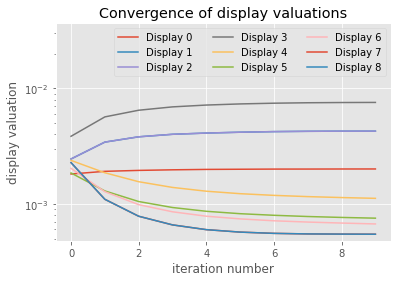

In [30]:
def plot_scenario_valuation(scenario_valuations_df, ax):
  display_types = sorted(list(scenario_valuations_df.columns))
  for display_type in display_types:
    ax.plot(scenario_valuations_df[display_type], label=display_type)

  ax.set_title('Convergence of display valuations')
  ax.set_ylabel('display valuation')
  ax.set_xlabel('iteration number')
  ax.set_yscale('log')
  ax.set_ylim([None, ax.get_ylim()[1] * (ax.get_ylim()[1] / ax.get_ylim()[0]) ** 0.5]) # Add some space at the top
  ax.legend(loc='upper right', ncol=3)

fig, ax = plt.subplots(1, 1)
scenario_valuations_df = pd.read_csv(get_scenario_valuations_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION))
plot_scenario_valuation(scenario_valuations_df, ax)

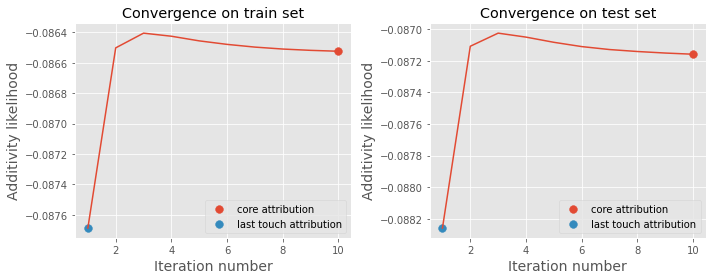

In [31]:
def plot_additivity_likelihood(additivity_likelihoods, ax):
  ax.plot(range(1, len(additivity_likelihoods) + 1), additivity_likelihoods)
  ax.set_ylabel('Additivity likelihood', fontsize=14)
  ax.set_xlabel('Iteration number', fontsize=14)

  llh_init = additivity_likelihoods[0]
  llh_conv = additivity_likelihoods[-1]
  ax.scatter(len(additivity_likelihoods), llh_conv, s=60, label=f'core attribution', c='C0')
  ax.scatter(1, llh_init, s=60, label=f'last touch attribution', c='C1')
  ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
metrics_df = pd.read_csv(get_metrics_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION))
plot_additivity_likelihood(metrics_df["train_additivity_likelihood"].values, axes[0])
axes[0].set_title('Convergence on train set')
plot_additivity_likelihood(metrics_df["test_additivity_likelihood"].values, axes[1])
axes[1].set_title('Convergence on test set')
fig.tight_layout()

In [32]:
# Saving figures for paper
metrics_df = pd.read_csv(get_metrics_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION))

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_additivity_likelihood(metrics_df["train_additivity_likelihood"].values, ax)
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('additive_likelihood_on_train_set.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_additivity_likelihood(metrics_df["test_additivity_likelihood"].values, ax)
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('additive_likelihood_on_test_set.pdf')
plt.close(fig)

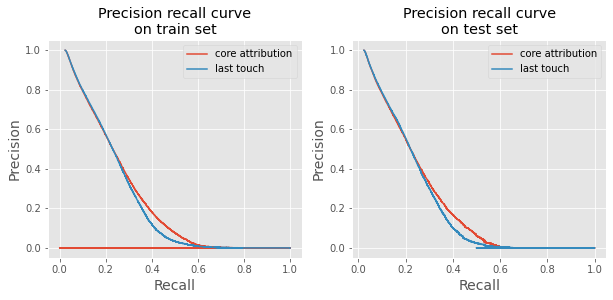

In [33]:
def plot_precision_recall_curve(ca_labels, ca_predictions, lt_labels, lt_predictions, ax):
  np.testing.assert_array_equal(ca_labels, lt_labels)
  ca_precision, ca_recall, _ = sklearn.metrics.precision_recall_curve(ca_labels, ca_predictions)
  ax.plot(ca_precision, ca_recall, label='core attribution')
  lt_precision, lt_recall, _ = sklearn.metrics.precision_recall_curve(lt_labels, lt_predictions)
  ax.plot(lt_precision, lt_recall, label='last touch')
  
  ax.set_ylabel('Precision', fontsize=14)
  ax.set_xlabel('Recall', fontsize=14)
  ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ca_labels, ca_predictions = joblib.load(get_conversion_probabilities_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION, 'core_attribution_model_train'))
lt_labels, lt_predictions = joblib.load(get_conversion_probabilities_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION, 'last_touch_model_train'))
plot_precision_recall_curve(ca_labels, ca_predictions, lt_labels, lt_predictions, axes[0])
axes[0].set_title('Precision recall curve\non train set')

ca_labels, ca_predictions = joblib.load(get_conversion_probabilities_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION, 'core_attribution_model_test'))
lt_labels, lt_predictions = joblib.load(get_conversion_probabilities_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION, 'last_touch_model_test'))
plot_precision_recall_curve(ca_labels, ca_predictions, lt_labels, lt_predictions, axes[1])
axes[1].set_title('Precision recall curve\non test set')
None

### Qualitative checks

In [34]:
def relative_valuation_given_time_since_last_click(preprocessed_dataset, debug_sample, hash_space, c_regularization):
  # Load models and data
  core_attribution_model = joblib.load(get_core_attribution_model_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION))
  last_touch_model = joblib.load(get_last_touch_model_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION))
  
  is_training_mask = split_train_test_mask(preprocessed_dataset)
  (
    train_labels, train_features,
    test_labels, test_features
  ) = get_train_test_labels_and_features(preprocessed_dataset, is_training_mask, hash_space=hash_space, use_cache=True)
  
  # Compute model valuations
  df = pd.DataFrame()
  df['last_touch_valuation'] = last_touch_model.predict_proba(train_features)[:, 1]
  df['core_attribution_valuation'] = core_attribution_model.predict_proba(train_features)[:, 1]
  df['relative_valuation'] = (df['core_attribution_valuation'] - df['last_touch_valuation']) / df['last_touch_valuation']

  # Time since last click
  packed_hours = 12
  df['hour_since_last_click'] = (
    preprocessed_dataset['time_since_last_click'][is_training_mask].values / (packed_hours * 3600)
  ).astype(int) * packed_hours
  
  (
    df[df['hour_since_last_click'] > 0][['hour_since_last_click', 'relative_valuation']]
    .groupby('hour_since_last_click')
    .mean()
    .reset_index()
  ).to_csv(
    get_valuations_given_time_since_last_click_path(debug_sample, hash_space, c_regularization)
  )
  
  # Number of clicks already made
  df['number_of_clicks'] = preprocessed_dataset['nb_clicks'][is_training_mask].values
  (
    df[['number_of_clicks', 'relative_valuation']]
    .groupby('number_of_clicks')
    .mean()
    .reset_index()
  ).to_csv(
    get_valuations_given_number_of_clicks_path(debug_sample, hash_space, c_regularization)
  )
  
relative_valuation_given_time_since_last_click(preprocessed_dataset, DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION)

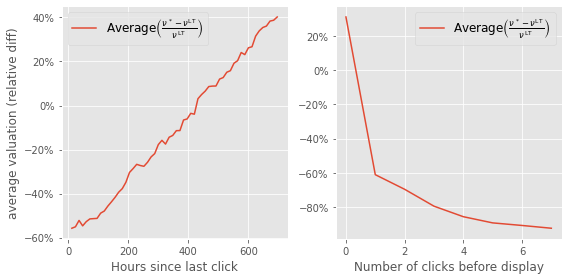

In [35]:
tslc_mean_scores_df = pd.read_csv(get_valuations_given_time_since_last_click_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION))
nb_clicks_mean_scores_df = pd.read_csv(get_valuations_given_number_of_clicks_path(DEBUG_SAMPLE, HASH_SPACE, C_REGULARIZATION))

rel_diff_label=r'$\mathrm{Average} \left( \frac{\nu^* - \nu^{\mathrm{LT}}}{\nu^{\mathrm{LT}}} \right)$'

def plot_time_since_last_click(tslc_mean_scores_df, ax):
  n_hours = 700
  ax.plot(
    tslc_mean_scores_df['hour_since_last_click'][tslc_mean_scores_df['hour_since_last_click'] <= n_hours],
    tslc_mean_scores_df['relative_valuation'][tslc_mean_scores_df['hour_since_last_click'] <= n_hours] * 100,
    label=rel_diff_label
  )
  
  ax.yaxis.set_major_formatter(PercentFormatter())
  
  ax.set_xlabel('Hours since last click')
  ax.legend(fontsize=12)

    
def plot_nb_clicks(nb_clicks_mean_scores_df, ax):
  keep_x_nclicks = 7
  ax.plot(
    nb_clicks_mean_scores_df['number_of_clicks'][nb_clicks_mean_scores_df['number_of_clicks'] <= keep_x_nclicks], 
    nb_clicks_mean_scores_df['relative_valuation'][nb_clicks_mean_scores_df['number_of_clicks'] <= keep_x_nclicks] * 100, 
    label=rel_diff_label,
  )
  ax.set_xlabel('Number of clicks before display')
  ax.yaxis.set_major_formatter(PercentFormatter())
  ax.legend(fontsize=12)


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_time_since_last_click(tslc_mean_scores_df, axes[0])
axes[0].set_ylabel('average valuation (relative diff)')
plot_nb_clicks(nb_clicks_mean_scores_df, axes[1])

fig.tight_layout()

In [36]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_time_since_last_click(tslc_mean_scores_df, ax)
ax.set_ylabel('average valuation (relative diff)')
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('relative_score_given_time_since_last_click.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_nb_clicks(nb_clicks_mean_scores_df, ax)
ax.set_ylabel('average valuation (relative diff)')
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('relative_score_given_nb_clicks.pdf')
plt.close(fig)

### For several feature space sizes

To  put  these  results  in  perspective,  we  additionally  tested  the  sensitivity  of  our  results  withrespect  to  the  size  of  the  feature  space.  Indeed,  with  the  hashing  trick,  we  are  embedding  our feature space into a target space whose size can be controlled

In [37]:
%%time
def launch_experiment_for_one_feature_space_size(n_iterations, preprocessed_dataset, hash_space, c_regularization):
  # Load data
  is_training_mask = split_train_test_mask(preprocessed_dataset)
  (
    train_labels, train_features,
    test_labels, test_features
  ) = get_train_test_labels_and_features(preprocessed_dataset, is_training_mask, hash_space=hash_space, use_cache=True)
  (
    is_clicked_train, timeline_ids_train, total_timeline_id_rewards_train,
    is_clicked_test, timeline_ids_test, total_timeline_id_rewards_test,
  ) = get_train_test_extra_core_attribution_attributes(preprocessed_dataset, is_training_mask)

  # Train models
  last_touch_model = train_last_touch_model(train_labels, train_features, c_regularization)
  core_attribution_model = train_core_attribution_model(10, train_labels, train_features, timeline_ids_train, total_timeline_id_rewards_train, is_clicked_train, c_regularization)

  # Compute train and test metrics
  return (
    compute_metrics(last_touch_model, train_features, timeline_ids_train, total_timeline_id_rewards_train),
    compute_metrics(last_touch_model, test_features, timeline_ids_test, total_timeline_id_rewards_test),
    compute_metrics(core_attribution_model, train_features, timeline_ids_train, total_timeline_id_rewards_train),
    compute_metrics(core_attribution_model, test_features, timeline_ids_test, total_timeline_id_rewards_test),
  )


def launch_experiment_for_several_feature_space_sizes(n_iterations, preprocessed_dataset, hash_spaces, n_jobs, debug_sample, c_regularization):
  parallel_result = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(launch_experiment_for_one_feature_space_size)
    (n_iterations, preprocessed_dataset, hash_space, c_regularization) 
    for hash_space in hash_spaces
  )

  def _unstack_result(stacked_result):
    metric_names = stacked_result[0].keys()
    return {
      metric_name: [metrics[metric_name] for metrics in stacked_result]
      for metric_name in metric_names
    }

  (
    train_last_touch_metrics, test_last_touch_metrics,
    train_core_attribution_metrics, test_core_attribution_metrics,
  ) = map(_unstack_result, zip(*parallel_result))
  
  metrics = {'hash_spaces': hash_spaces}
  metric_names = train_last_touch_metrics.keys()
  for metric_name in metric_names:
    for result, result_name in [
      (train_last_touch_metrics, 'train_last_touch'), 
      (train_core_attribution_metrics, 'train_core_attribution'),
      (test_last_touch_metrics, 'test_last_touch'),
      (test_core_attribution_metrics, 'test_core_attribution'),
    ]:
      metrics[f'{result_name}_{metric_name}'] = result[metric_name]

  pd.DataFrame(metrics).to_csv(get_metrics_with_hashspace_path(debug_sample, c_regularization), index=False)


hash_spaces = [int(2**space) for space in range(10, 17)]
n_jobs = len(hash_spaces)
launch_experiment_for_several_feature_space_sizes(10, preprocessed_dataset, hash_spaces, n_jobs, DEBUG_SAMPLE, C_REGULARIZATION)

CPU times: user 34.3 s, sys: 7.81 s, total: 42.1 s
Wall time: 4h 19min 2s


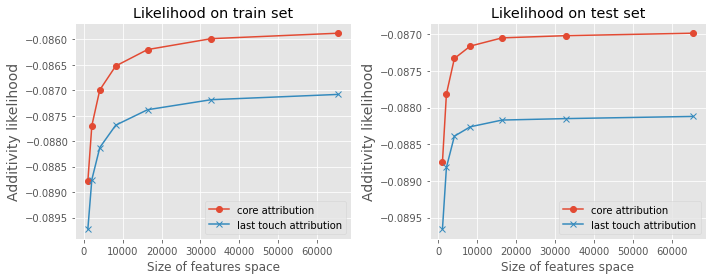

In [38]:
def plot_metric_given_hashspace(hash_spaces, additivity_likelihoods, last_touch_likelihoods, ax, metric_label):
  ax.plot(hash_spaces, additivity_likelihoods, label='core attribution', marker='o')
  ax.plot(hash_spaces, last_touch_likelihoods, label='last touch attribution', marker='x')

  ax.set_ylabel(metric_label, fontsize=14)
  ax.set_xlabel('Size of features space')
  ax.legend(loc='lower right')

metrics_df = pd.read_csv(get_metrics_with_hashspace_path(DEBUG_SAMPLE, C_REGULARIZATION))
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
plot_metric_given_hashspace(
  metrics_df['hash_spaces'],
  metrics_df['train_core_attribution_additivity_likelihood'],
  metrics_df['train_last_touch_additivity_likelihood'], 
  axes[0], "Additivity likelihood"
)
axes[0].set_title('Likelihood on train set')
plot_metric_given_hashspace(
  metrics_df['hash_spaces'],
  metrics_df['test_core_attribution_additivity_likelihood'],
  metrics_df['test_last_touch_additivity_likelihood'],
  axes[1], "Additivity likelihood"
)
axes[1].set_title('Likelihood on test set')

fig.tight_layout()

In [39]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_metric_given_hashspace(
  metrics_df['hash_spaces'],
  metrics_df['train_core_attribution_additivity_likelihood'],
  metrics_df['train_last_touch_additivity_likelihood'], 
  ax, "Additivity likelihood"
)
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('additive_likelihood_given_features_space_on_train_set.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_metric_given_hashspace(
  metrics_df['hash_spaces'],
  metrics_df['test_core_attribution_additivity_likelihood'],
  metrics_df['test_last_touch_additivity_likelihood'],
  ax, "Additivity likelihood"
)
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('additive_likelihood_given_features_space_on_test_set.pdf')
plt.close(fig)

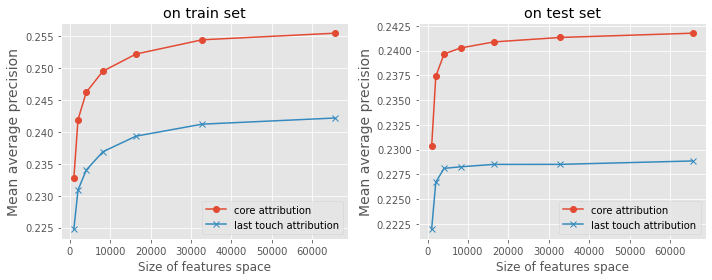

In [40]:
metrics_df = pd.read_csv(get_metrics_with_hashspace_path(DEBUG_SAMPLE, C_REGULARIZATION))
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
plot_metric_given_hashspace(
  metrics_df['hash_spaces'],
  metrics_df['train_core_attribution_average_precision'],
  metrics_df['train_last_touch_average_precision'], 
  axes[0], "Mean average precision"
)
axes[0].set_title('on train set')
plot_metric_given_hashspace(
  metrics_df['hash_spaces'],
  metrics_df['test_core_attribution_average_precision'],
  metrics_df['test_last_touch_average_precision'],
  axes[1], "Mean average precision"
)
axes[1].set_title('on test set')

fig.tight_layout()

In [41]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_metric_given_hashspace(
  metrics_df['hash_spaces'],
  metrics_df['train_core_attribution_average_precision'],
  metrics_df['train_last_touch_average_precision'], 
  ax, "Mean average precision"
)
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('average_precision_given_features_space_on_train_set.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_metric_given_hashspace(
  metrics_df['hash_spaces'],
  metrics_df['test_core_attribution_average_precision'],
  metrics_df['test_last_touch_average_precision'],
  ax, "Mean average precision"
)
fig.subplots_adjust(bottom=0.15, left=0.2, top=0.95, right=0.95)
plt.savefig('average_precision_given_features_space_on_test_set.pdf')
plt.close(fig)